The Dataset_Stroke.csv file can be used to predict whether a patient is likely to get stroke based on several attributes like gender, age, various diseases, and smoking status. The dataset contains 5110 observations.
   
Attribute information:

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
12. stroke: 1 if the patient had a stroke or 0 if not


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc



**Procedure:**
1. Import data and make data frame
2. Convert a categorical variable to binary with dummies(one-hot encoding)
3. define x and y
4. split train and test
5. Demonstrate each variable distribution to check normality
6. fill NA with numerical mean and categorical mode
7. SMOTE because data is imbalanced we need more data in minority which is here is not stroke
8. PCA feature reduction: but it only gives 2 component so we did this just for information of which feature are more important but we are not use it and also **PCA is not recommended at all for categorical variables**
9. define models(Extra tees, logistic, SVM linear and non linear, KNeighbors)
10. Tune hyperparameter for best 2 models which means **SVM non linear** and **Extra trees**
11. Compute f1, precision and recall but because we have imbalance data it cannot be good measure
12. **ROC and AUC are better** measure to evaluate our models
13. cross-validation accuracy for comparing the scores cross different groups
14. comparing ROC to choose the best model

In [4]:
data = pd.read_csv('Dataset_Stroke.csv')
data.head()
data.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

# convert categorical stringes to binary variables

In [5]:
data = pd.get_dummies(data, columns=['gender', 'work_type', 'Residence_type', 'smoking_status','ever_married'], drop_first=True)
print(data.head())


      id   age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0   9046  67.0             0              1             228.69  36.6       1   
1  51676  61.0             0              0             202.21   NaN       1   
2  31112  80.0             0              1             105.92  32.5       1   
3  60182  49.0             0              0             171.23  34.4       1   
4   1665  79.0             1              0             174.12  24.0       1   

   gender_Male  gender_Other  work_type_Never_worked  work_type_Private  \
0         True         False                   False               True   
1        False         False                   False              False   
2         True         False                   False               True   
3        False         False                   False               True   
4        False         False                   False              False   

   work_type_Self-employed  work_type_children  Residence_type_Urban

In [6]:
print(data['stroke'].value_counts())

stroke
0    4861
1     249
Name: count, dtype: int64


Data are imbalanced; for 4861 people who have non-stroke and 249 who have stroke, we should use a balancing technique like down sampling and up sampling. i choose SMOT


**Our data type:**

   **categorical**: gender, married, worktype(5), residence type(2), smoking(4)

  **numerical**: age, hypertension, heart disease, glucose, bmi, stroke

In [7]:
y=data['stroke']
x=data.drop(['id','stroke'],axis=1)


In [8]:
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=42)


# Variable distribution graphs

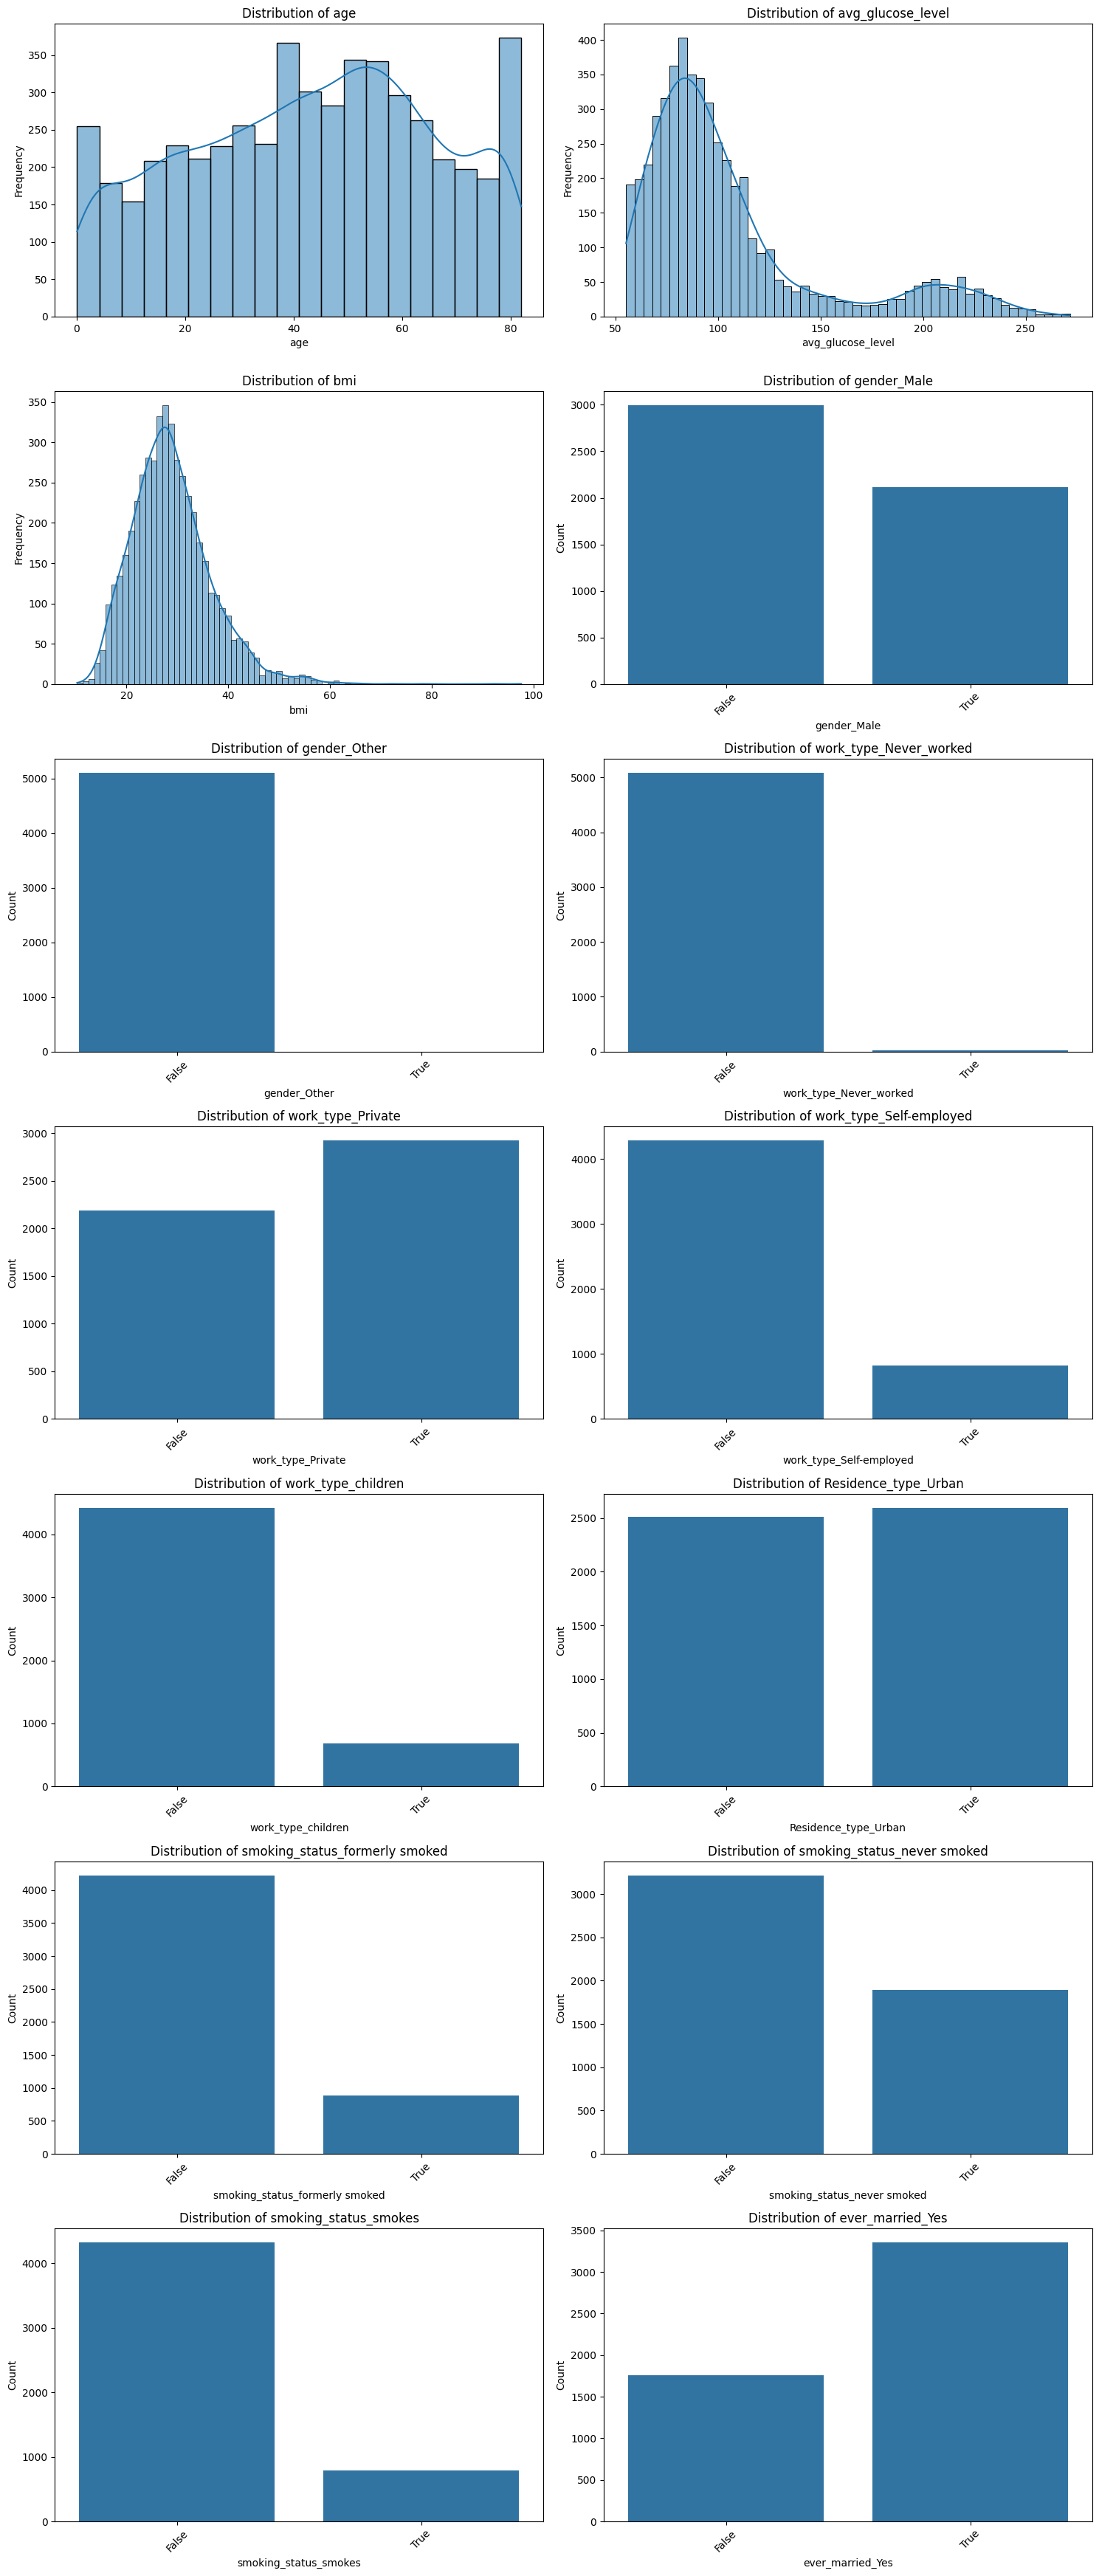

In [9]:
categorical_cols = [col for col in x_tr.columns if col.startswith(('gender_', 'work_type_', 'Residence_type_', 'smoking_status_', 'ever_married_'))]
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

total_plots = len(numerical_cols) + len(categorical_cols)
n_cols = 2
n_rows = (total_plots + 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()


for i, col in enumerate(numerical_cols):
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j, col in enumerate(categorical_cols, start=len(numerical_cols)):
    sns.countplot(x=col, data=data, ax=axes[j])
    axes[j].set_title(f'Distribution of {col}')
    axes[j].set_xlabel(col)
    axes[j].set_ylabel('Count')
    for label in axes[j].get_xticklabels():
        label.set_rotation(45)

# Hide unused axes if there are any
for k in range(total_plots, n_rows * n_cols):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


# **NAN data**:
I used Imputing to fill the unknown data
, Put mean in numerical gap and mode in categorical gap

In [10]:
categorical_cols = [col for col in x_tr.columns if col.startswith(('gender_', 'work_type_', 'Residence_type_', 'smoking_status_', 'ever_married_'))]
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

x_tr[numerical_cols] = x_tr[numerical_cols].fillna(x_tr[numerical_cols].mean())
x_te[numerical_cols] = x_te[numerical_cols].fillna(x_te[numerical_cols].mean())


for col in categorical_cols:
    x_tr[col] = x_tr[col].fillna(x_tr[col].mode()[0])
for col in categorical_cols:
    x_te[col] = x_te[col].fillna(x_te[col].mode()[0])


# **standarized:**
according to the distribution we dont need it

#Dealing with data imbalance: approach SMOTE

In [11]:
print(y_tr.value_counts())

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(x_tr, y_tr)
print(y_train_smote.value_counts())

stroke
0    3417
1     160
Name: count, dtype: int64
stroke
0    3417
1    3417
Name: count, dtype: int64


# Dimensionality reduction: approach PCA

In [12]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_smote)
x_te_pca = pca.transform(x_te)

print("Number of components:", pca.n_components_)
print("Total explained variance: %.2f" % np.sum(pca.explained_variance_ratio_))
print("Original data: ", X_train_smote.shape)
print("Compressed data: ", X_train_pca.shape)
print(f"PCA reduced the feature space to {pca.n_components_} principal components")


Number of components: 2
Total explained variance: 0.99
Original data:  (6834, 16)
Compressed data:  (6834, 2)
PCA reduced the feature space to 2 principal components


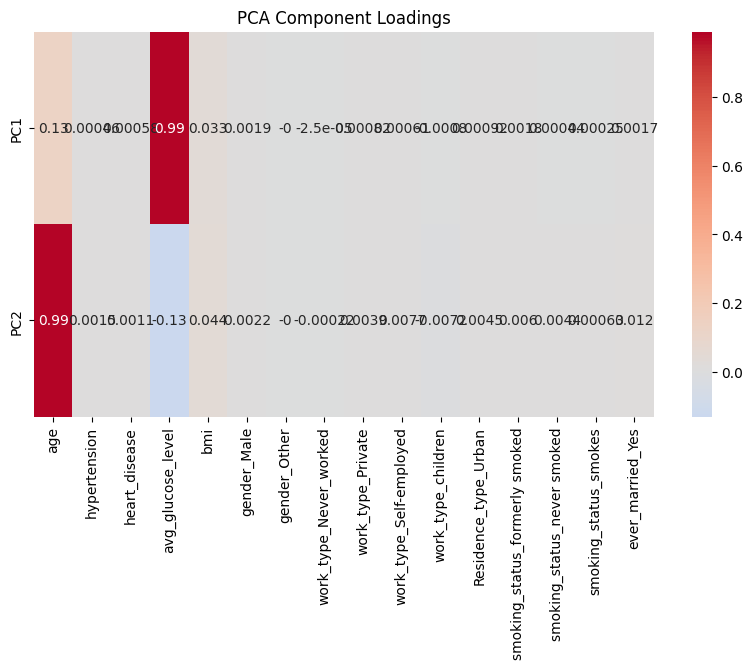

In [13]:
# Get the loadings (contribution of each feature to each component)
loadings = pca.components_

# Create a DataFrame for better visualization of loadings
features = list(x.columns)  # Adjust this if your features are in a DataFrame
loading_matrix = pd.DataFrame(loadings, columns=features, index=['PC1', 'PC2'])

plt.figure(figsize=(10, 5))
sns.heatmap(loading_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings')
plt.show()



According to the PCA analysis, the variables 'age' and 'average glucose level' alone can account for 99% of the variance in distinguishing between stroke and non-stroke groups. However, I chose to **proceed with all variables without applying PCA.** This decision was based on the recommendation against using PCA on categorical variables, which comprise a significant portion of our dataset

# **Models**

In [14]:
model_tree = ExtraTreesClassifier().fit(X_train_smote, y_train_smote)
model_logistic = LogisticRegression().fit(X_train_smote, y_train_smote);
model_svm_lin = SVC(kernel="linear", C=1, probability=True).fit(X_train_smote, y_train_smote);
model_svm_nonlin = SVC(kernel="rbf", gamma=1, C=1, probability=True).fit(X_train_smote, y_train_smote);
model_knn = KNeighborsClassifier(2).fit(X_train_smote, y_train_smote);

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
print("\t\t TR \t TE")
print("Extra-trees acc: %.2f\t %.2f" % (model_tree.score(X_train_smote, y_train_smote), model_tree.score(x_te, y_te)))
print("Logistic acc:\t %.2f\t %.2f" % (model_logistic.score(X_train_smote, y_train_smote), model_logistic.score(x_te, y_te)))
print("SVM-lin acc:\t %.2f\t %.2f" % (model_svm_lin.score(X_train_smote, y_train_smote), model_svm_lin.score(x_te, y_te)))
print("SVM-RBF acc:\t %.2f\t %.2f" % (model_svm_nonlin.score(X_train_smote, y_train_smote), model_svm_nonlin.score(x_te, y_te)))
print("K-NN acc:\t %.2f\t %.2f" % (model_knn.score(X_train_smote, y_train_smote), model_knn.score(x_te, y_te)))

		 TR 	 TE
Extra-trees acc: 1.00	 0.92
Logistic acc:	 0.88	 0.84
SVM-lin acc:	 0.88	 0.85
SVM-RBF acc:	 1.00	 0.94
K-NN acc:	 0.99	 0.87


# Adjusting hyperparameters to determine the optimal model between the two candidates:
1. SVM non linear
2. Extra trees

# 1. SVM non linear,AUC=0.66, Acc TR=1 and TE=0.94

For imbalanced data, tune hyperparameters  with accuracy is not helpful and AUC differences are more informative                                                  


# Tuning hyperparameters:   

To refine the hyperparameter tuning process, the search space was expanded beyond the initial boundaries when the optimal parameters were identified at the extremes (**ceiling or floor**). This ensures that all potential optimal values are thoroughly explored.

In [17]:
parameters_grid_svm = {
    'C': [0.1,1, 10, 100,1000],
    'gamma': [1, 0.1, 0.01,0.001],
    'kernel': ['rbf']
}

grid_search_svm = GridSearchCV(model_svm_nonlin, parameters_grid_svm, cv=5, scoring='accuracy', return_train_score=False)
tune_svm = grid_search_svm.fit(X_train_smote, y_train_smote)

pd.DataFrame(grid_search_svm.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
print("Best Accuracy: ", tune_svm.best_score_)
print("Best parameters: ", tune_svm.best_params_)
print("Best estimator: ",tune_svm.best_estimator_)



Best Accuracy:  0.957272821720089
Best parameters:  {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator:  SVC(C=1000, gamma=0.01, probability=True)


Best Accuracy:  0.957272821720089
Best parameters:  {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator:  SVC(C=1000, gamma=0.01, probability=True)


Put best hyperparameters in the model and train it again

In [49]:
model_tune_svm = SVC(kernel="rbf", gamma=0.01, C=1000, probability=True).fit(X_train_smote, y_train_smote)

y_proba = model_tune_svm.predict_proba(x_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, y_proba)
roc_auc = auc(fpr, tpr)

print("AUC (Area Under Curve):", roc_auc)
print("SVM-RBF acc:\t %.2f\t %.2f" % (model_tune_svm.score(X_train_smote, y_train_smote), model_tune_svm.score(x_te, y_te)))

AUC (Area Under Curve): 0.7005859192629712
SVM-RBF acc:	 1.00	 0.91


This is the best AUC we can get from the SVM model with tuned hyperparameters

# F1, Precision, Recall
First, the relation between precision and recall is plotted to find the threshold. Because data are imbalanced, its necessary to find an optimized threshold

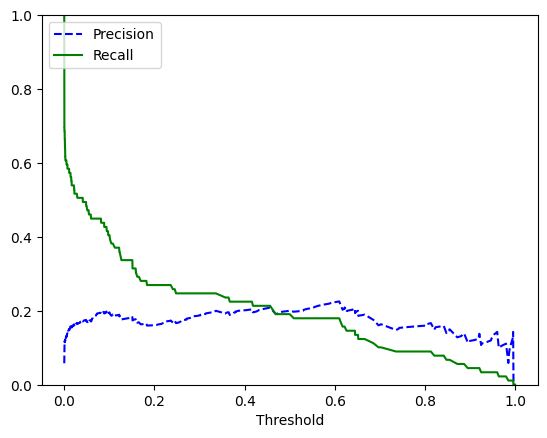

In [23]:
probabilities = model_tune_svm.predict_proba(x_te)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_te, probabilities)

plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0,1])
plt.show()

Confusion Matrix:
 [[1372   72]
 [  70   19]]
              precision    recall  f1-score   support

   not-strok       0.95      0.95      0.95      1444
       strok       0.21      0.21      0.21        89

    accuracy                           0.91      1533
   macro avg       0.58      0.58      0.58      1533
weighted avg       0.91      0.91      0.91      1533

Precision: 0.2087912087912088
Recall: 0.21348314606741572
F1 Score: 0.2111111111111111


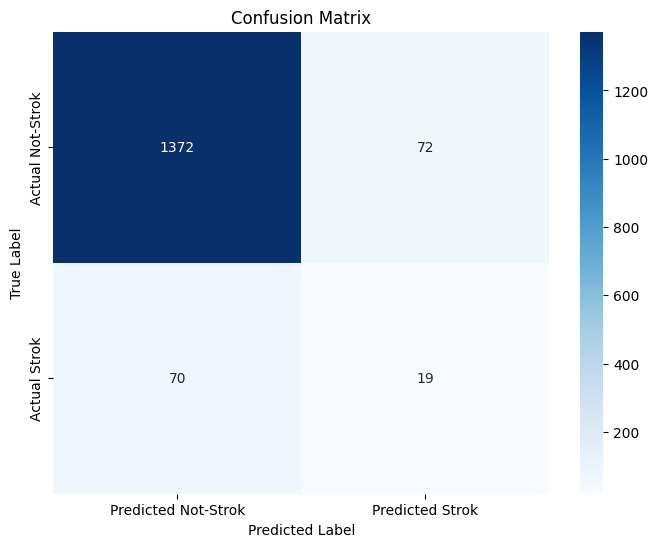

In [24]:
threshold = 0.45

y_pred = (y_proba >= threshold).astype(int)

conf_matrix = confusion_matrix(y_te, y_pred)  # Make sure y_test is your actual test labels
print("Confusion Matrix:\n", conf_matrix)

print(classification_report(y_te, y_pred, target_names=['not-strok', 'strok']))

precision = precision_score(y_te, y_pred)
recall = recall_score(y_te, y_pred)
f1 = f1_score(y_te, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Predicted Not-Strok', 'Predicted Strok'],
            yticklabels=['Actual Not-Strok', 'Actual Strok'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


# ROC and AUC
Comparing before and after tunning

AUC before tunning: 0.6629952690715553
AUC after tunning: 0.7005859192629712


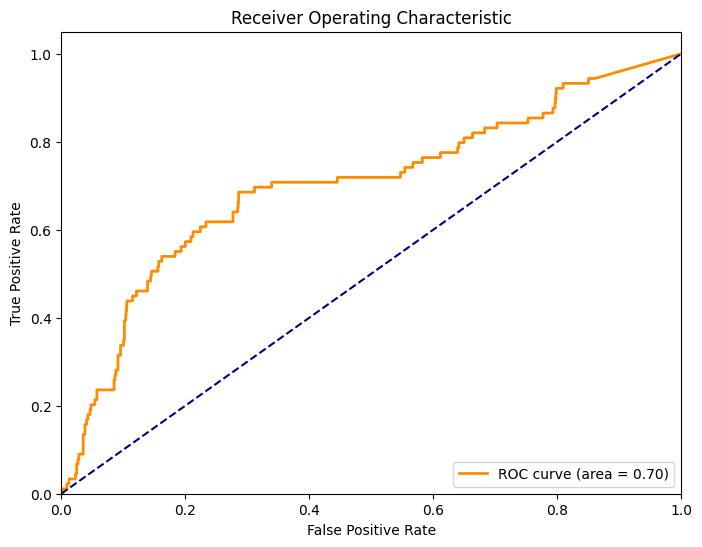

AUC (Area Under Curve): 0.7005859192629712


In [60]:
y_proba_svm = model_svm_nonlin.predict_proba(x_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, y_proba_svm)
roc_auc1 = auc(fpr, tpr)
print("AUC before tunning:", roc_auc1)

y_proba_svmtune = model_tune_svm.predict_proba(x_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, y_proba_svmtune)
roc_auc2 = auc(fpr, tpr)
print("AUC after tunning:", roc_auc2)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC (Area Under Curve):", roc_auc)


Svm non linear summary:

Precision: 0.2087912087912088
Recall: 0.21348314606741572
F1 Score: 0.2111111111111111
ROC: 0.7
AUC: 0.7

# 2. Extra trees, evaluation the best model

To refine the hyperparameter tuning process, the search space was expanded beyond the initial boundaries when the optimal parameters were identified at the extremes (**ceiling or floor**). This ensures that all potential optimal values are thoroughly explored.

In [37]:

param_grid = {
    'n_estimators': [90,100,150],  # Number of trees
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [ 30,40,50],   # Maximum number of levels in tree
    'min_samples_split': [2,3,4],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1,2,3]      # Minimum number of samples required at each leaf node
}


grid_search_tree = GridSearchCV(model_tree, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

best_model = grid_search_tree.fit(X_train_pca, y_train_smote)

print("Best Accuracy: ", best_model.best_score_)
print("Best parameters: ", best_model.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py",

Best Accuracy:  0.8582096713903654
Best parameters:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


In [51]:
best_model = ExtraTreesClassifier(max_depth=50, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 4, n_estimators= 100).fit(X_train_smote, y_train_smote)
print("SVM-RBF acc:\t %.2f\t %.2f" % (best_model.score(X_train_smote, y_train_smote), best_model.score(x_te, y_te)))

SVM-RBF acc:	 1.00	 0.92


**First time adjusting boundaries :** After 7 min processing:
Best Accuracy:  0.9525902870527954
Best parameters:  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

**second time adjusting boundaries:**
Best Accuracy:  0.8546972616399314** bold text
Best parameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

**Third time adjusting boundaries:**Best Accuracy:  0.8582096713903654
Best parameters:  {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}

# F1, Precision, Recall
First, the relation between precision and recall is plotted to find the threshold. Because data are imbalanced, its necessary to find an optimized threshold

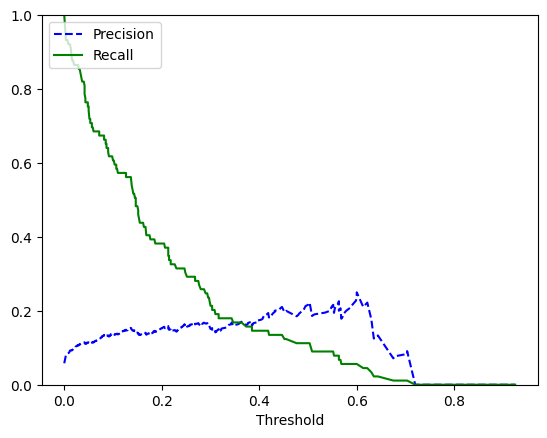

In [52]:
probabilities = best_model.predict_proba(x_te)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_te, probabilities)

plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0,1])
plt.show()


**Because data are imbalanced, we need to find a threshold for precision and recall**

Confusion Matrix:
 [[1371   73]
 [  75   14]]
              precision    recall  f1-score   support

   not-strok       0.95      0.95      0.95      1444
       strok       0.16      0.16      0.16        89

    accuracy                           0.90      1533
   macro avg       0.55      0.55      0.55      1533
weighted avg       0.90      0.90      0.90      1533

Precision: 0.16091954022988506
Recall: 0.15730337078651685
F1 Score: 0.1590909090909091


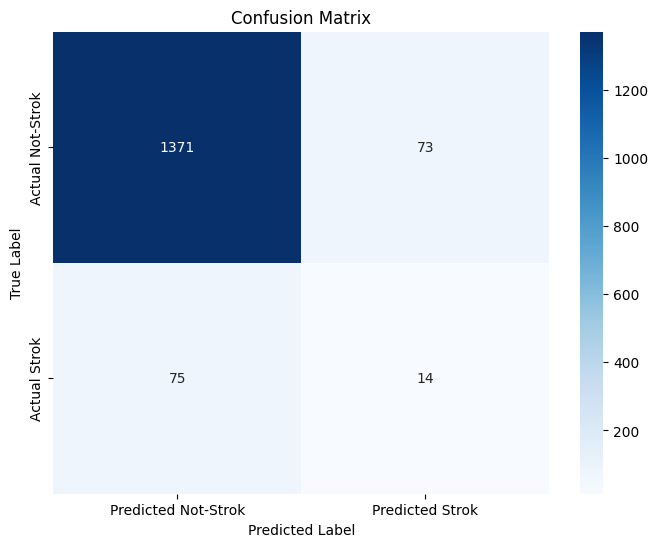

In [53]:
y_proba = best_model.predict_proba(x_te)[:, 1]

# Define custom threshold
threshold = 0.37

y_pred = (y_proba >= threshold).astype(int)

conf_matrix = confusion_matrix(y_te, y_pred)  # Make sure y_test is your actual test labels
print("Confusion Matrix:\n", conf_matrix)

print(classification_report(y_te, y_pred, target_names=['not-strok', 'strok']))

precision = precision_score(y_te, y_pred)
recall = recall_score(y_te, y_pred)
f1 = f1_score(y_te, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Predicted Not-Strok', 'Predicted Strok'],
            yticklabels=['Actual Not-Strok', 'Actual Strok'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


extra tree summary:

Precision: 0.19
Recall: 0.13
F1 Score: 0.16
ROC: 0.75
AUC (Area Under Curve): 0.74

# ROC and AOC for extra trees

AUC before tunning: 0.7559914718789877
AUC after tunning: 0.7536182265243236


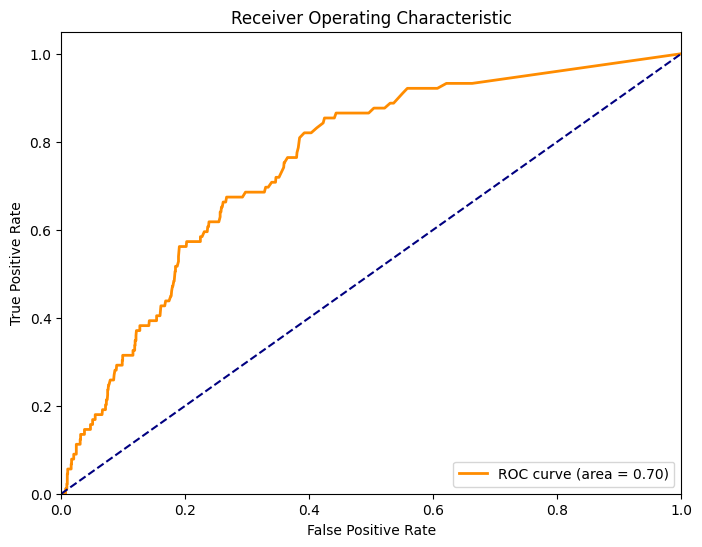

AUC (Area Under Curve): 0.7005859192629712


In [61]:
y_proba3 = model_tree.predict_proba(x_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, y_proba3)
roc_auc3 = auc(fpr, tpr)
print("AUC before tunning:", roc_auc3)

y_proba4 = best_model.predict_proba(x_te)[:, 1]
fpr, tpr, thresholds = roc_curve(y_te, y_proba4)
roc_auc4 = auc(fpr, tpr)
print("AUC after tunning:", roc_auc4)


# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC (Area Under Curve):", roc_auc)


# Cross-Validation Accuracy Scores for extra forest

I know it is already done in the gridsearch but i just want to see the score results

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, x, y, scoring='accuracy', cv=skf)

print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Average Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")


Cross-Validation Accuracy Scores: [0.94129159 0.94129159 0.94716243 0.94716243 0.94520548]
Average Cross-Validation Accuracy: 0.94 ± 0.00


# Choosing the best model: Extra forest

According to the ROC and AUC after hyperparameter adjacent the **extra forest model**(0.75) preform better than non linear SVM(0.70) so we can choose it as best model

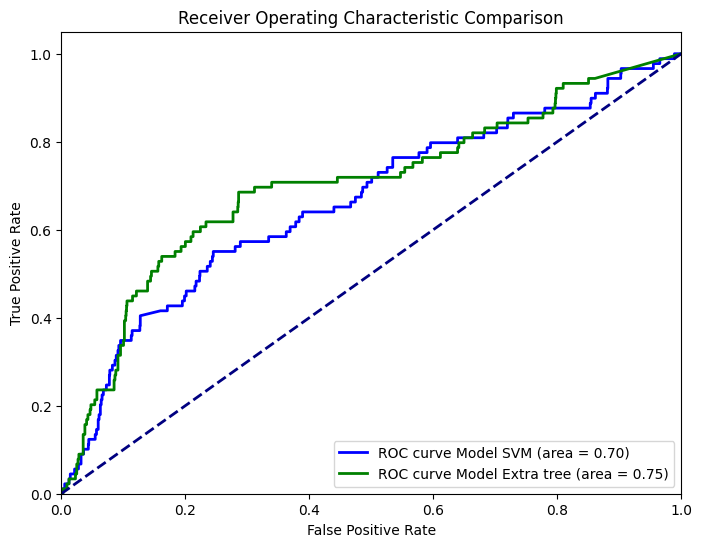

In [69]:
# Calculate ROC curve and AUC for the SVM
fpr, tpr, _ = roc_curve(y_te, y_proba_svmtune)
roc_auc2 = auc(fpr, tpr)

# Calculate ROC curve and AUC for the extra tree
fpr, tpr, _ = roc_curve(y_te, y_proba4)
roc_auc4 = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='blue', lw=2, label='ROC curve Model SVM (area = %0.2f)' % roc_auc2)
plt.plot(fpr2, tpr2, color='green', lw=2, label='ROC curve Model Extra tree (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()
